
Calculating QSC capacity for different error probabilities...
Pe	Capacity	Optimal Distribution
------------------------------------------------------------
0.00	2.0000	[0.250, 0.250, 0.250, 0.250]


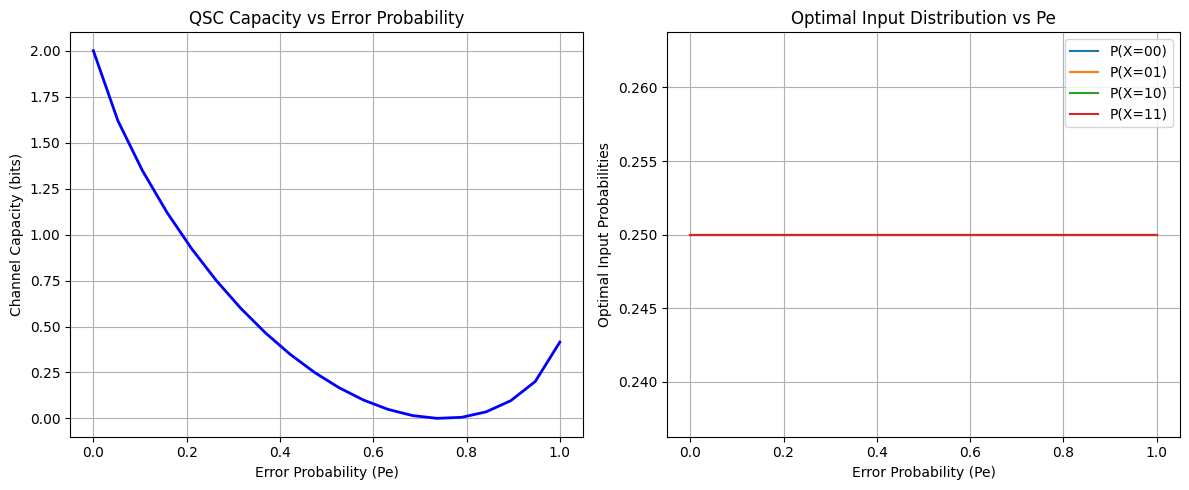

In [3]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def create_qsc_joint_matrix(px, pe):
    """
    Create joint probability matrix for Quaternary Symmetric Channel.

    Parameters:
    px: array of input probabilities [p(00), p(01), p(10), p(11)]
    pe: error probability (total probability of error, split equally among wrong symbols)

    Returns:
    4x4 joint probability matrix P(X,Y)
    """
    # For QSC, error probability is split equally among wrong symbols
    pe_individual = pe / 3  # probability of each specific error
    pc = 1 - pe  # probability of correct transmission

    # Create transition probability matrix P(Y|X)
    transition_matrix = np.full((4, 4), pe_individual)
    np.fill_diagonal(transition_matrix, pc)

    # Create joint probability matrix
    return px.reshape(-1, 1) * transition_matrix

def calculate_mutual_information(px, pe):
    """
    Calculate mutual information I(X;Y) for QSC.

    Parameters:
    px: array of input probabilities
    pe: error probability

    Returns:
    Mutual information in bits
    """
    # Input entropy H(X)
    hx = -np.sum(px[px > 0] * np.log2(px[px > 0]))

    # Get joint probability matrix
    joint_matrix = create_qsc_joint_matrix(px, pe)

    # Calculate P(Y) by summing columns
    py = np.sum(joint_matrix, axis=0)

    # Calculate conditional probabilities P(X|Y)
    conditional_probs = np.divide(joint_matrix, py,
                                out=np.zeros_like(joint_matrix),
                                where=py != 0)

    # Calculate H(X|Y)
    hx_given_y = 0
    nonzero_mask = joint_matrix > 0
    hx_given_y = -np.sum(joint_matrix[nonzero_mask] *
                        np.log2(conditional_probs[nonzero_mask]))

    return hx - hx_given_y

def optimize_qsc_capacity(pe):
    """
    Find channel capacity and optimal input distribution for QSC.

    Parameters:
    pe: error probability

    Returns:
    (capacity, optimal_distribution)
    """
    # Objective function to minimize (negative mutual information)
    def objective(px_partial):
        # Convert 3 variables to 4 probabilities that sum to 1
        px = np.append(px_partial, 1 - np.sum(px_partial))
        if np.any(px < 0):  # Check if valid probability distribution
            return float('inf')
        return -calculate_mutual_information(px, pe)

    # Constraints: probabilities must sum to <= 1
    constraints = [{
        'type': 'ineq',
        'fun': lambda x: 1 - np.sum(x)
    }]

    # Bounds for each probability: [0, 1]
    bounds = [(0, 1)] * 3

    # Initial guess: uniform distribution
    initial_guess = np.array([0.25] * 3)

    # Optimize
    result = minimize(objective, initial_guess,
                     bounds=bounds,
                     constraints=constraints,
                     method='SLSQP')

    # Get full probability distribution
    optimal_px = np.append(result.x, 1 - np.sum(result.x))
    capacity = -result.fun

    return capacity, optimal_px

# Example usage and visualization
if __name__ == "__main__":
    # Calculate capacity for different error probabilities
    pe_values = np.linspace(0, 1, 20)
    capacities = []
    optimal_distributions = []

    print("\nCalculating QSC capacity for different error probabilities...")
    print("Pe\tCapacity\tOptimal Distribution")
    print("-" * 60)

    for pe in pe_values:
        capacity, opt_dist = optimize_qsc_capacity(pe)
        capacities.append(capacity)
        optimal_distributions.append(opt_dist)

        if pe in [0, 0.25, 0.5, 0.75]:
            dist_str = ", ".join([f"{p:.3f}" for p in opt_dist])
            print(f"{pe:.2f}\t{capacity:.4f}\t[{dist_str}]")

    # Plot results
    plt.figure(figsize=(12, 5))

    # Plot capacity vs Pe
    plt.subplot(1, 2, 1)
    plt.plot(pe_values, capacities, 'b-', linewidth=2)
    plt.grid(True)
    plt.xlabel('Error Probability (Pe)')
    plt.ylabel('Channel Capacity (bits)')
    plt.title('QSC Capacity vs Error Probability')

    # Plot optimal input distributions
    plt.subplot(1, 2, 2)
    optimal_distributions = np.array(optimal_distributions)
    for i in range(4):
        plt.plot(pe_values, optimal_distributions[:, i],
                label=f'P(X={i:02b})')

    plt.grid(True)
    plt.xlabel('Error Probability (Pe)')
    plt.ylabel('Optimal Input Probabilities')
    plt.title('Optimal Input Distribution vs Pe')
    plt.legend()

    plt.tight_layout()
    plt.show()